# **REGRESIÓN MULTIPLE**

In [1]:
import os
import pandas as pd
import pickle
import urllib.request
import kagglehub
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt #Graficar
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import math
import logging
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_white
from statsmodels.sandbox.stats.runs import runstest_1samp
import mlflow
from scipy.stats import kstest
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
import networkx as nx


c:\Users\eliana\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Descargar dataset con kagglehub (lo guarda en cache interna)
path = kagglehub.dataset_download("ranjeetjain3/seaborn-tips-dataset")

# Copiar el dataset descargado a la ruta que definida
destino = "MLOPS_Project/data"
shutil.copytree(path, destino, dirs_exist_ok=True)

print("Dataset guardado en:", destino)

Dataset guardado en: MLOPS_Project/data


In [3]:
#Instalar el complementos
%pip install factor_analyzer
%pip install networkx
%pip install mlflow
%matplotlib inline


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
datos = pd.read_csv("MLOPS_Project/data/tips.csv")

In [5]:
#Obtengo los Ln
continuas=datos[["total_bill","tip","size"]]
continuas_L = pd.DataFrame()
for col in continuas.columns:
    col_data = continuas[col]
    min_val = col_data.min()

    if (col_data < 0).any():
        desplazamiento = abs(min_val) + 1
        continuas_L[f"{col}_L"] = np.log(col_data + desplazamiento)

    elif (col_data == 0).any():
        continuas_L[f"{col}_L"] = np.log(col_data.replace(0, 1))
    else:
        continuas_L[f"{col}_L"] = np.log(col_data)

In [6]:
# Validar si hay columnas duplicadas antes de concatenar
columnas_duplicadas = [col for col in continuas_L.columns if col in datos.columns]

if columnas_duplicadas:
    print("🚫 No se puede concatenar. Las siguientes columnas ya existen en 'datos':")
    for col in columnas_duplicadas:
        print(f" - {col}")
    print("🛑 Ajusta los nombres de las columnas para evitar conflictos.")
else:
    # Si no hay conflicto, concatena
    datos = pd.concat([datos, continuas_L], axis=1)
    print("✅ Componentes concatenados correctamente.")
    display(datos.head())


✅ Componentes concatenados correctamente.


,total_bill,tip,sex,smoker,day,time,size,total_bill_L,tip_L,size_L
0,16.99,1.01,Female,No,Sun,Dinner,2,2.832625,0.009950,0.693147
1,10.34,1.66,Male,No,Sun,Dinner,3,2.336020,0.506818,1.098612
2,21.01,3.50,Male,No,Sun,Dinner,3,3.044999,1.252763,1.098612
3,23.68,3.31,Male,No,Sun,Dinner,2,3.164631,1.196948,0.693147
4,24.59,3.61,Female,No,Sun,Dinner,4,3.202340,1.283708,1.386294


# **Pertinencia de la regresión múltiple: explorar los datos**

In [7]:
#Se dividen los datos en entrenamiento y testeo
np.random.seed(101)
sample = np.random.choice(datos.index, size=int(0.8 * len(datos)), replace=False)
train = datos.loc[sample]
test = datos.drop(sample)
display(train.head())
display(test.head())

,total_bill,tip,sex,smoker,day,time,size,total_bill_L,tip_L,size_L
151,13.13,2.00,Male,No,Sun,Dinner,2,2.574900,0.693147,0.693147
34,17.78,3.27,Male,No,Sat,Dinner,2,2.878074,1.184790,0.693147
109,14.31,4.00,Female,Yes,Sat,Dinner,2,2.660959,1.386294,0.693147
4,24.59,3.61,Female,No,Sun,Dinner,4,3.202340,1.283708,1.386294
114,25.71,4.00,Female,No,Sun,Dinner,3,3.246880,1.386294,1.098612


,total_bill,tip,sex,smoker,day,time,size,total_bill_L,tip_L,size_L
5,25.29,4.71,Male,No,Sun,Dinner,4,3.230409,1.549688,1.386294
7,26.88,3.12,Male,No,Sun,Dinner,4,3.291383,1.137833,1.386294
8,15.04,1.96,Male,No,Sun,Dinner,2,2.710713,0.672944,0.693147
11,35.26,5.00,Female,No,Sun,Dinner,4,3.562749,1.609438,1.386294
19,20.65,3.35,Male,No,Sat,Dinner,3,3.027715,1.208960,1.098612


# **Desarrollo del modelo de Regresión Múltiple**

In [8]:
#Separar las variables explicatorias
X_train = train[["total_bill","tip","size"]]
X_train_L = train[["total_bill_L","tip_L","size_L"]]

## **Existencia del modelo**

In [9]:
#Verificar la existencia del modelo
# Mi pregunta: ¿El valor total de la cuenta y el tamaño del grupo influyen en el valor de la propina?

# Y = tip_L
# X1 = total_bill_L
# X2 = size_L

formula_m = 'tip_L ~ total_bill_L+size_L'
model_m = sm.formula.ols(formula_m, data=train).fit()
aov_table_m =  sm.stats.anova_lm(model_m,typ=2)
aov_table_m

,sum_sq,df,F,PR(>F)
total_bill_L,7.157521,1.0,64.368522,9.983559e-14
size_L,0.445431,1.0,4.005820,4.675146e-02
Residual,21.349629,192.0,NaN,NaN


## **Pruebas invividuales y el ajuste del modelo**

In [10]:
import statsmodels.api as sm
from IPython.display import Markdown, display

# Mostrar resumen del modelo
summary_m = model_m.summary()
print(summary_m)

# =============================
# Interpretación automática
# =============================
r2 = model_m.rsquared
adj_r2 = model_m.rsquared_adj
f_pvalue = model_m.f_pvalue
p_values = model_m.pvalues
coefs = model_m.params
conf_int = model_m.conf_int()

interpretacion = []
recomendaciones = []

interpretacion.append("📌 **Resumen del modelo de regresión múltiple (Interpretación Automática ):**\n")

# Interpretación del R²
interpretacion.append(f"🔎 El modelo tiene un coeficiente de determinación **R² = {r2:.3f}** y ajustado **R²_adj = {adj_r2:.3f}**, lo que indica que explica aproximadamente el **{r2*100:.1f}%** de la variabilidad de la propina (en escala logarítmica).")

if r2 < 0.4:
    recomendaciones.append("🔍 *El R² es relativamente bajo. Considera agregar nuevas variables que puedan explicar mejor el comportamiento de las propinas.*")
elif r2 > 0.8:
    recomendaciones.append("✅ *El modelo tiene un buen poder explicativo. Verifica que no haya sobreajuste si estás usando muchas variables.*")

# Valor F
interpretacion.append(f"📈 La prueba global del modelo (F-statistic) tiene un valor-p de **{f_pvalue:.2e}**, lo que indica que el modelo en su conjunto es **estadísticamente significativo**.")

# Interpretación por variable
interpretacion.append("\n🔬 **Análisis de variables independientes:**")
for var in p_values.index:
    pval = p_values[var]
    beta = coefs[var]
    intervalo = conf_int.loc[var]

    if pval < 0.05:
        interpretacion.append(f"✅ **{var}**: significativa (p = {pval:.3f}), con coeficiente = {beta:.3f}. Intervalo de confianza: [{intervalo[0]:.3f}, {intervalo[1]:.3f}]")
        if beta > 0:
            recomendaciones.append(f"➡️ *Cuando **{var}** aumenta, la propina tiende a aumentar.*")
        else:
            recomendaciones.append(f"⬅️ *Cuando **{var}** aumenta, la propina tiende a disminuir.*")
    else:
        interpretacion.append(f"⚠️ **{var}**: NO significativa (p = {pval:.3f}). Intervalo de confianza: [{intervalo[0]:.3f}, {intervalo[1]:.3f}]")
        recomendaciones.append(f"❌ *Considera eliminar **{var}** del modelo o investigar si tiene una relación no lineal con la variable dependiente.*")

# =============================
# Mostrar en Colab
# =============================

display(Markdown("\n".join(interpretacion)))
display(Markdown("🧠 **Recomendaciones basadas en los resultados:**"))
display(Markdown("\n".join(recomendaciones)))


                            OLS Regression Results                            
Dep. Variable:                  tip_L   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     69.30
Date:                Mon, 06 Oct 2025   Prob (F-statistic):           2.20e-23
Time:                        18:32:48   Log-Likelihood:                -61.026
No. Observations:                 195   AIC:                             128.1
Df Residuals:                     192   BIC:                             137.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.7562      0.164     -4.602   

📌 **Resumen del modelo de regresión múltiple (Interpretación Automática ):**

🔎 El modelo tiene un coeficiente de determinación **R² = 0.419** y ajustado **R²_adj = 0.413**, lo que indica que explica aproximadamente el **41.9%** de la variabilidad de la propina (en escala logarítmica).
📈 La prueba global del modelo (F-statistic) tiene un valor-p de **2.20e-23**, lo que indica que el modelo en su conjunto es **estadísticamente significativo**.

🔬 **Análisis de variables independientes:**
✅ **Intercept**: significativa (p = 0.000), con coeficiente = -0.756. Intervalo de confianza: [-1.080, -0.432]
✅ **total_bill_L**: significativa (p = 0.000), con coeficiente = 0.548. Intervalo de confianza: [0.414, 0.683]
✅ **size_L**: significativa (p = 0.047), con coeficiente = 0.181. Intervalo de confianza: [0.003, 0.359]

🧠 **Recomendaciones basadas en los resultados:**

⬅️ *Cuando **Intercept** aumenta, la propina tiende a disminuir.*
➡️ *Cuando **total_bill_L** aumenta, la propina tiende a aumentar.*
➡️ *Cuando **size_L** aumenta, la propina tiende a aumentar.*

En este modelo buscamos entender si el total de la cuenta (total_bill_L) y el tamaño del grupo (size_L) influyen sobre el valor de la propina (tip_L), usando una regresión múltiple con variables logarítmicas.

Ambas variables resultaron significativas estadísticamente, lo que confirma que sí tienen un impacto sobre la propina. El total de la cuenta es el que más influye, pero el tamaño del grupo también aporta al comportamiento.

El modelo logra explicar un 41.9% de la variabilidad de la propina, lo cual no está mal para un primer acercamiento con solo dos variables.

Detectamos una posible ligera desviación de la normalidad en los residuos, así que más adelante podríamos revisar eso con más detalle. Sin embargo, no hay autocorrelación y el modelo cumple con buena parte de los supuestos básicos.

En resumen, la propina se ve afectada tanto por lo que se gasta como por cuántas personas están en la mesa, y el modelo nos permite predecir con una precisión razonable. Aún hay espacio para mejorar, posiblemente incluyendo nuevas variables o transformaciones.

## **Validacion de Supuestos**

## **No existencia de Multicolinealidad**

C:\Users\eliana\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


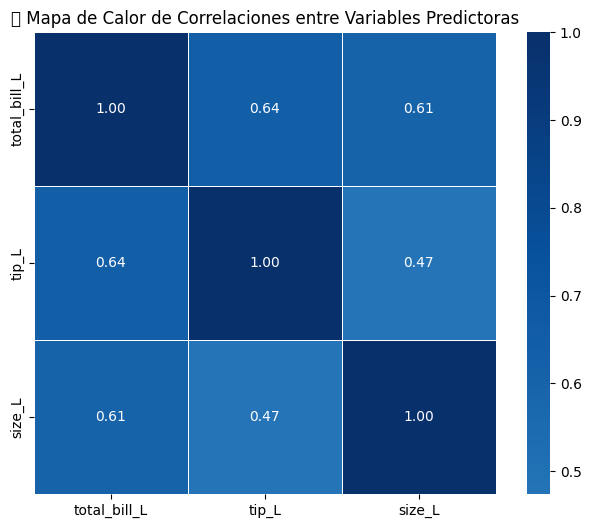

### 📌 Interpretación de Correlaciones entre Variables

✅ **total_bill_L** y **tip_L** tienen una correlación moderada de **0.64**.
✅ **total_bill_L** y **size_L** tienen una correlación moderada de **0.61**.
🔎 **tip_L** y **size_L** tienen una correlación baja de **0.47**.

✅ No se detectaron correlaciones preocupantes entre las variables.

In [11]:
#Análisis de correlaciones para variables en data set de entrenamiento. ( OJO acá estamos poniendo las logaritmicas)

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Markdown, display

# Matriz de correlaciones
correlation_matrix = X_train_L.corr()

# Visualización de mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="Blues", center=0, fmt=".2f", square=True, linewidths=0.5)
plt.title("🔍 Mapa de Calor de Correlaciones entre Variables Predictoras")
plt.show()

# =====================================
# Interpretación automática
# =====================================

interpretaciones = []
recomendaciones = []

# Iterar sobre la matriz de correlaciones
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        var1 = correlation_matrix.columns[i]
        var2 = correlation_matrix.columns[j]
        corr = correlation_matrix.iloc[i, j]

        # Clasificación de la correlación
        if abs(corr) >= 0.8:
            interpretaciones.append(f"⚠️ **{var1}** y **{var2}** tienen una correlación muy fuerte de **{corr:.2f}**.")
            recomendaciones.append(f"🔍 *Revisa si ambas variables son necesarias en el modelo. Podrías considerar eliminar una para evitar multicolinealidad.*")
        elif abs(corr) >= 0.5:
            interpretaciones.append(f"✅ **{var1}** y **{var2}** tienen una correlación moderada de **{corr:.2f}**.")
        elif abs(corr) >= 0.3:
            interpretaciones.append(f"🔎 **{var1}** y **{var2}** tienen una correlación baja de **{corr:.2f}**.")
        else:
            interpretaciones.append(f"ℹ️ **{var1}** y **{var2}** tienen muy poca correlación (**{corr:.2f}**).")

# Mostrar resultados
display(Markdown("### 📌 Interpretación de Correlaciones entre Variables"))
display(Markdown("\n".join(interpretaciones)))

if recomendaciones:
    display(Markdown("### 🧠 Recomendaciones basadas en correlaciones"))
    display(Markdown("\n".join(set(recomendaciones))))
else:
    display(Markdown("✅ No se detectaron correlaciones preocupantes entre las variables."))


In [12]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from IPython.display import Markdown, display

# ===============================
# Cálculo de VIF
# ===============================
vif = pd.DataFrame()
vif["features"] = X_train_L.columns
vif["VIF Factor"] = [variance_inflation_factor(X_train_L.values, i) for i in range(X_train_L.shape[1])]

# ===============================
# Mostrar tabla VIF
# ===============================
display(Markdown("### 📊 Tabla de VIF (Factor de Inflación de Varianza)"))
display(vif.round(2))

# ===============================
# Interpretación automática
# ===============================
interpretaciones = []
recomendaciones = []

for index, row in vif.iterrows():
    feature = row['features']
    vif_value = row['VIF Factor']

    if vif_value > 10:
        interpretaciones.append(f"⚠️ **{feature}** presenta una **multicolinealidad muy severa** (VIF = {vif_value:.2f}).")
        recomendaciones.append(f"🔍 Considera eliminar o combinar **{feature}** con otra variable para mejorar la estabilidad del modelo.")
    elif vif_value > 5:
        interpretaciones.append(f"🔶 **{feature}** tiene una **multicolinealidad moderada** (VIF = {vif_value:.2f}).")
        recomendaciones.append(f"📌 Revisa si **{feature}** es esencial para el modelo.")
    else:
        interpretaciones.append(f"✅ **{feature}** tiene un VIF bajo (VIF = {vif_value:.2f}), lo que indica baja multicolinealidad.")

# ===============================
# Mostrar interpretación
# ===============================
display(Markdown("### 📌 Interpretación de VIF por variable"))
display(Markdown("\n".join(interpretaciones)))

if recomendaciones:
    display(Markdown("### 🧠 Recomendaciones para mejorar el modelo"))
    display(Markdown("\n".join(set(recomendaciones))))
else:
    display(Markdown("✅ No se detectaron problemas de multicolinealidad. ¡Buen trabajo!"))


### 📊 Tabla de VIF (Factor de Inflación de Varianza)

,features,VIF Factor
0,total_bill_L,17.30
1,tip_L,9.74
2,size_L,13.00


### 📌 Interpretación de VIF por variable

⚠️ **total_bill_L** presenta una **multicolinealidad muy severa** (VIF = 17.30).
🔶 **tip_L** tiene una **multicolinealidad moderada** (VIF = 9.74).
⚠️ **size_L** presenta una **multicolinealidad muy severa** (VIF = 13.00).

### 🧠 Recomendaciones para mejorar el modelo

🔍 Considera eliminar o combinar **total_bill_L** con otra variable para mejorar la estabilidad del modelo.
📌 Revisa si **tip_L** es esencial para el modelo.
🔍 Considera eliminar o combinar **size_L** con otra variable para mejorar la estabilidad del modelo.

### **Hay Multicolinealidad**



**Solución de la multicolinealidad: se debe solucionar en todo el conjunto de datos y volver a dividir en train y test**

In [13]:
#Estamos tomando la información de las variables ya pasadas por logaritmo.
explicatorias=datos[["total_bill_L","tip_L","size_L"]]

In [14]:
#PCA Será aplicado a variables con logaritmo.
scaler = StandardScaler()
explicatorias_scaled = scaler.fit_transform(explicatorias)
pca = PCA()
res_pca = pca.fit(explicatorias_scaled)
cumVar = pd.DataFrame(np.cumsum(res_pca.explained_variance_ratio_)*100,
                      columns=["cumVarPerc"])
expVar = pd.DataFrame(res_pca.explained_variance_ratio_*100, columns=["VarPerc"])
pd.concat([expVar, cumVar], axis=1)\
    .rename(index={0: "PC1", 1: "PC2", 2: "PC3", 3: "PC4", 4: "PC5", 5: "PC6", 6: "PC7", 7: "PC8", 8: "PC9", 9: "PC10"})


,VarPerc,cumVarPerc
PC1,73.311032,73.311032
PC2,16.965385,90.276417
PC3,9.723583,100.000000


In [15]:
#Los loadings
np.set_printoptions(suppress=True)
print("\nCargas de los componentes (loadings):")
print(np.round(res_pca.components_, 4))


Cargas de los componentes (loadings):
[[ 0.608   0.5722  0.5503]
 [-0.1175 -0.6207  0.7752]
 [ 0.7852 -0.5361 -0.3101]]


In [16]:
# Create a DataFrame to display the loadings
loadings_df = pd.DataFrame(
    data=res_pca.components_.T,
    columns=[f"PC{i+1}" for i in range(res_pca.n_components_)],
    index=explicatorias.columns
)

# Display the loadings
display(loadings_df)

,PC1,PC2,PC3
total_bill_L,0.608048,-0.117539,0.785151
tip_L,0.572210,-0.620663,-0.536054
size_L,0.550322,0.775217,-0.310136


In [17]:
#Elegimos el número de componentes a guardar según el % de varianza acumulada
res_pca = pca.fit(explicatorias_scaled)
pred_pca = res_pca.transform(explicatorias_scaled)
df_pred = pd.DataFrame(pred_pca, columns=[f"PC{i+1}" for i in range(pred_pca.shape[1])])
#componentes = df_pred[["PC1"]].copy() #recuerde que acá guarda el número de componentes
componentes = df_pred[["PC1", "PC2"]].copy()


In [18]:
componentes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PC1     244 non-null    float64
 1   PC2     244 non-null    float64
dtypes: float64(2)
memory usage: 3.9 KB


In [19]:
# PCA con dos componentes principales
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Estandarizar variables continuas
scaler = StandardScaler()
continuas_scaled = scaler.fit_transform(continuas_L)

# Ajustar PCA
pca = PCA(n_components=2)  # 👉 Solo tomamos PC1 y PC2
pca_result = pca.fit(continuas_scaled)

# Cargas de los componentes (equivalente a cargas factoriales)
print("Cargas de los componentes:")
cargas = pd.DataFrame(pca.components_.T, index=continuas_L.columns, columns=["PC1", "PC2"])
print(cargas)

# Valores propios (eigenvalues)
print("\nValores propios:")
eigenvalues = pca.explained_variance_
print(eigenvalues)

# Varianza explicada, proporción y acumulada
varianza_explicada = pca.explained_variance_
proporcion_varianza = pca.explained_variance_ratio_
varianza_acumulada = proporcion_varianza.cumsum()

# Estructurar DataFrame resumen
df_varianza = pd.DataFrame({
    'Componente': ['PC1', 'PC2'],
    'Varianza Explicada': varianza_explicada,
    'Proporción (%)': proporcion_varianza * 100,
    'Acumulada (%)': varianza_acumulada * 100
})

df_varianza


Cargas de los componentes:
                   PC1       PC2
total_bill_L  0.608048 -0.117539
tip_L         0.572210 -0.620663
size_L        0.550322  0.775217

Valores propios:
[2.2083817  0.51105604]


,Componente,Varianza Explicada,Proporción (%),Acumulada (%)
0,PC1,2.208382,73.311032,73.311032
1,PC2,0.511056,16.965385,90.276417


In [20]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   total_bill    244 non-null    float64
 1   tip           244 non-null    float64
 2   sex           244 non-null    object 
 3   smoker        244 non-null    object 
 4   day           244 non-null    object 
 5   time          244 non-null    object 
 6   size          244 non-null    int64  
 7   total_bill_L  244 non-null    float64
 8   tip_L         244 non-null    float64
 9   size_L        244 non-null    float64
dtypes: float64(5), int64(1), object(4)
memory usage: 19.2+ KB


In [21]:
# Validar si hay columnas duplicadas antes de concatenar
columnas_duplicadas = [col for col in componentes.columns if col in datos.columns]

if columnas_duplicadas:
    print("🚫 No se puede concatenar. Las siguientes columnas ya existen en 'datos':")
    for col in columnas_duplicadas:
        print(f" - {col}")
    print("🛑 Ajusta los nombres de las columnas para evitar conflictos.")
    display(datos.head())
else:
    # Si no hay conflicto, concatena
    datos = pd.concat([datos, componentes], axis=1)
    print("✅ Componentes concatenados correctamente.")
    display(datos.head())


✅ Componentes concatenados correctamente.


,total_bill,tip,sex,smoker,day,time,size,total_bill_L,tip_L,size_L,PC1,PC2
0,16.99,1.01,Female,No,Sun,Dinner,2,2.832625,0.009950,0.693147,-1.712620,0.969288
1,10.34,1.66,Male,No,Sun,Dinner,3,2.336020,0.506818,1.098612,-1.062917,1.360340
2,21.01,3.50,Male,No,Sun,Dinner,3,3.044999,1.252763,1.098612,0.902003,0.106399
3,23.68,3.31,Male,No,Sun,Dinner,2,3.164631,1.196948,0.693147,0.308759,-0.812399
4,24.59,3.61,Female,No,Sun,Dinner,4,3.202340,1.283708,1.386294,1.647817,0.705635


**Volvemos a dividir los datos en entrenamiento (train) y testeo (test)**

In [22]:
np.random.seed(101)
sample = np.random.choice(datos.index, size=int(0.8 * len(datos)), replace=False)
train = datos.loc[sample]
test = datos.drop(sample)
display(train.head())
display(test.head())

,total_bill,tip,sex,smoker,day,time,size,total_bill_L,tip_L,size_L,PC1,PC2
151,13.13,2.00,Male,No,Sun,Dinner,2,2.574900,0.693147,0.693147,-1.172280,0.064256
34,17.78,3.27,Male,No,Sat,Dinner,2,2.878074,1.184790,0.693147,-0.105055,-0.718159
109,14.31,4.00,Female,Yes,Sat,Dinner,2,2.660959,1.386294,0.693147,-0.141578,-0.947225
4,24.59,3.61,Female,No,Sun,Dinner,4,3.202340,1.283708,1.386294,1.647817,0.705635
114,25.71,4.00,Female,No,Sun,Dinner,3,3.246880,1.386294,1.098612,1.357822,-0.138187


,total_bill,tip,sex,smoker,day,time,size,total_bill_L,tip_L,size_L,PC1,PC2
5,25.29,4.71,Male,No,Sun,Dinner,4,3.230409,1.549688,1.386294,2.036449,0.318831
7,26.88,3.12,Male,No,Sun,Dinner,4,3.291383,1.137833,1.386294,1.579667,0.889747
8,15.04,1.96,Male,No,Sun,Dinner,2,2.710713,0.672944,0.693147,-1.010287,0.056616
11,35.26,5.00,Female,No,Sun,Dinner,4,3.562749,1.609438,1.386294,2.576390,0.144441
19,20.65,3.35,Male,No,Sat,Dinner,3,3.027715,1.208960,1.098612,0.820425,0.173497


## **No existencia de Multicolinealidad**

Realizamos nuevamente la regresión ya sin la multicolinealidad

**El modelo con el PCA**

In [23]:
# 📌 Modelo de regresión múltiple con dos componentes principales (PCA)
formula_PCA = 'tip_L ~ PC1 + PC2'
model_PCA = sm.formula.ols(formula_PCA, data=train).fit()

# 📊 ANOVA para evaluar la significancia global del modelo
aov_table = sm.stats.anova_lm(model_PCA, typ=2)
display(aov_table)

# 🧠 Interpretación automática del ANOVA
print("\n🧠 Interpretación del ANOVA del modelo con PCA:")
for index, row in aov_table.iterrows():
    if pd.notnull(row['PR(>F)']):
        p_value = row['PR(>F)']
        f_stat = row['F']
        print(f"\n🔹 Componente: {index}")
        print(f"   - Valor F: {f_stat:.2f}")
        print(f"   - Valor p: {p_value:.2e}")

        if p_value < 0.05:
            print("   ✅ Este componente es estadísticamente significativo para explicar 'tip_L'.")
        else:
            print("   ⚠️ Este componente NO es estadísticamente significativo.")
    else:
        print(f"\n🧾 Residual: Sin prueba de significancia (es la varianza no explicada del modelo).")


,sum_sq,df,F,PR(>F)
PC1,26.321908,1.0,1455.997788,1.430241e-91
PC2,7.888629,1.0,436.359951,2.551693e-51
Residual,3.471026,192.0,NaN,NaN



🧠 Interpretación del ANOVA del modelo con PCA:

🔹 Componente: PC1
   - Valor F: 1456.00
   - Valor p: 1.43e-91
   ✅ Este componente es estadísticamente significativo para explicar 'tip_L'.

🔹 Componente: PC2
   - Valor F: 436.36
   - Valor p: 2.55e-51
   ✅ Este componente es estadísticamente significativo para explicar 'tip_L'.

🧾 Residual: Sin prueba de significancia (es la varianza no explicada del modelo).


In [24]:
# 📋 Obtener el resumen del modelo
summary_PCA = model_PCA.summary()
print(summary_PCA)

# 🧠 Interpretación automatizada
print("\n🧠 Interpretación del modelo con componentes principales (PCA):")
coefs = model_PCA.params
pvalues = model_PCA.pvalues
std_err = model_PCA.bse

for var in coefs.index:
    coef = coefs[var]
    pval = pvalues[var]
    err = std_err[var]

    print(f"\n🔹 Variable: {var}")
    print(f"   - Coeficiente: {coef:.4f}")
    print(f"   - Error estándar: {err:.4f}")
    print(f"   - Valor p: {pval:.4f}")

    if pval < 0.001:
        nivel = "🚀 Altamente significativo"
    elif pval < 0.05:
        nivel = "✅ Significativo"
    elif pval < 0.1:
        nivel = "⚠️ Marginalmente significativo"
    else:
        nivel = "❌ No significativo"

    interpretacion = (
        f"   ➕ Un aumento en '{var}' se asocia con un cambio de {coef:.4f} en 'tip_L', "
        "manteniendo constantes los demás componentes." if var != 'Intercept'
        else f"   📍 El valor promedio de 'tip_L' cuando todas las variables son 0 es {coef:.4f}."
    )

    print(f"   - Nivel de significancia: {nivel}")
    print(interpretacion)


                            OLS Regression Results                            
Dep. Variable:                  tip_L   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     920.8
Date:                Mon, 06 Oct 2025   Prob (F-statistic):           4.03e-99
Time:                        18:32:50   Log-Likelihood:                 116.09
No. Observations:                 195   AIC:                            -226.2
Df Residuals:                     192   BIC:                            -216.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9990      0.010    103.647      0.0

## **Validación de supuestos: ya no validamos multicolinealidad**

## **Correcta especificación del modelo**

**Planteamos las hipótesis**

 $$ H_{0}:\text{El modelo se encuentra correctamente especificado}$$
 $$ H_{1}:\text{El modelo se NO encuentra correctamente especificado}$$

 Si el valor p es menor a 0.05 se debe rechazar H0

In [25]:
# 🔍 Prueba RESET de Ramsey para el modelo PCA
reset_result = linear_reset(model_PCA, power=2, use_f=True)
print(reset_result)

# 🧠 Interpretación automática
print("\n🧠 Interpretación automática de la prueba RESET de Ramsey:")

f_stat = reset_result.fvalue
p_val = reset_result.pvalue
alpha = 0.05

print(f"\n📊 Estadístico F: {f_stat:.4f}")
print(f"📉 Valor p: {p_val:.4f}")

if p_val < alpha:
    print(f"\n❌ Como el valor p < {alpha}, rechazamos H₀.")
    print("   ↪ Esto sugiere que el modelo puede estar mal especificado. Podría faltar alguna variable o relación no lineal.")
    print("   🔁 Se recomienda revisar si faltan variables importantes o si hay que aplicar transformaciones.")
else:
    print(f"\n✅ Como el valor p ≥ {alpha}, no se rechaza H₀.")
    print("   ↪ El modelo parece estar correctamente especificado bajo los supuestos actuales.")
    print("   🧩 No hay evidencia suficiente para afirmar que falten relaciones importantes.")


<F test: F=2.7680686496474456, p=0.09780195073831535, df_denom=191, df_num=1>

🧠 Interpretación automática de la prueba RESET de Ramsey:

📊 Estadístico F: 2.7681
📉 Valor p: 0.0978

✅ Como el valor p ≥ 0.05, no se rechaza H₀.
   ↪ El modelo parece estar correctamente especificado bajo los supuestos actuales.
   🧩 No hay evidencia suficiente para afirmar que falten relaciones importantes.


Como 0.200068 > 0.05 no se debe rechazar H0, entonces el modelo con PCA se encuentra correctamente especificado =)


## **Homoscedasticidad de los residuales**

**Planteamos las hipótesis**

 $$ H_{0}:\text{Homoscedasticidad en los residuales}$$
 $$ H_{1}:\text{Heteroscedasticidad en los residuales}$$

 Si el valor p es menor a 0.05 se debe rechazar H0

In [26]:
# 📌 Prueba de White para homocedasticidad en el modelo PCA
resid = model_PCA.resid
exog = model_PCA.model.exog

white_test = het_white(resid, exog)
lm_stat, lm_pvalue, f_stat, f_pvalue = white_test

print(f"📊 Estadístico LM: {lm_stat:.4f}, p-valor LM: {lm_pvalue:.4f}")
print(f"📊 Estadístico F: {f_stat:.4f}, p-valor F: {f_pvalue:.4f}")

# 🧠 Interpretación automática
print("\n🧠 Interpretación automática de la prueba de White:")

alpha = 0.05

if lm_pvalue < alpha or f_pvalue < alpha:
    print(f"\n❌ Se rechaza H₀ con p-valor LM = {lm_pvalue:.4f} o p-valor F = {f_pvalue:.4f}")
    print("   ↪ Existe evidencia de heterocedasticidad en los residuos del modelo.")
    print("   ⚠️ Esto podría afectar la validez de las inferencias estadísticas.")
    print("   🔍 Considera usar correcciones robustas o revisar variables omitidas.")
else:
    print(f"\n✅ No se rechaza H₀ (p-valores LM = {lm_pvalue:.4f}, F = {f_pvalue:.4f})")
    print("   ↪ No hay evidencia de heterocedasticidad en los residuos.")
    print("   ✅ Los errores parecen tener varianza constante.")
    print("   🧩 El modelo es estadísticamente sólido en este aspecto.")


📊 Estadístico LM: 0.2042, p-valor LM: 0.9991
📊 Estadístico F: 0.0396, p-valor F: 0.9991

🧠 Interpretación automática de la prueba de White:

✅ No se rechaza H₀ (p-valores LM = 0.9991, F = 0.9991)
   ↪ No hay evidencia de heterocedasticidad en los residuos.
   ✅ Los errores parecen tener varianza constante.
   🧩 El modelo es estadísticamente sólido en este aspecto.


## **No autocorrelación en los residuales**

**Planteamos las hipótesis**

 $$ H_{0}:\text{Independencia en los residuales}$$
 $$ H_{1}:\text{Independencia en los residuales}$$

 Si el valor p es menor a 0.05 se debe rechazar H0

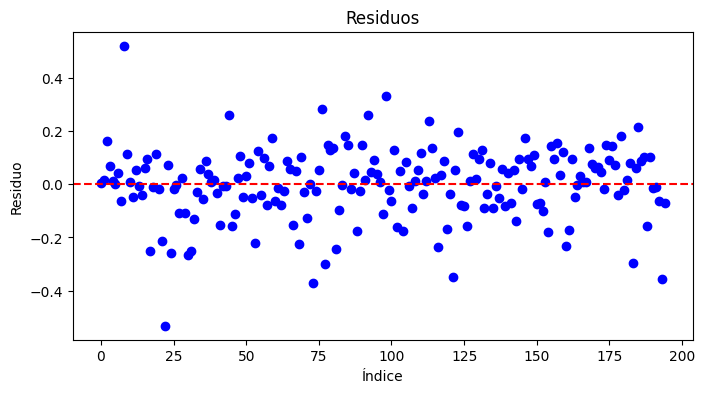

In [27]:
#El gráfico de residuos con PCA
residuosPCA = model_PCA.resid

plt.figure(figsize=(8, 4))
plt.scatter(range(len(residuosPCA)), residuosPCA, color='blue')
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuos")
plt.xlabel("Índice")
plt.ylabel("Residuo")
plt.show()

In [28]:
# 🧪 Runs test (Prueba de rachas) para autocorrelación en residuos
z_stat, p_value = runstest_1samp(residuosPCA)

print(f"📊 Estadístico Z = {z_stat:.4f}, p-valor = {p_value:.4f}")
print("\n🧠 Interpretación automática del Runs Test:")

alpha = 0.05

if p_value < alpha:
    print(f"❌ Se rechaza H₀ con p-valor = {p_value:.4f}")
    print("   ↪ Hay evidencia de autocorrelación en los residuos.")
    print("   ⚠️ Esto podría indicar patrones no capturados por el modelo.")
    print("   🔍 Considera revisar la estructura temporal o agregar variables.")
else:
    print(f"✅ No se rechaza H₀ (p-valor = {p_value:.4f})")
    print("   ↪ No hay evidencia de autocorrelación en los residuos.")
    print("   ✅ Los residuos se comportan como ruido aleatorio.")


📊 Estadístico Z = -0.2545, p-valor = 0.7991

🧠 Interpretación automática del Runs Test:
✅ No se rechaza H₀ (p-valor = 0.7991)
   ↪ No hay evidencia de autocorrelación en los residuos.
   ✅ Los residuos se comportan como ruido aleatorio.


## **Normalidad de los residuales**

**Planteamos las hipótesis**

 $$ H_{0}:\text{Los residuos provienen de una distribución Normal}$$
 $$ H_{1}:\text{Los residuos NO provienen de una distribución Normal}$$

 Si el valor p es menor a 0.05 se debe rechazar H0

In [29]:
# 🧪 Prueba de normalidad (Kolmogorov-Smirnov) para residuos
ks_stat, p_value = kstest(residuosPCA, 'norm', args=(np.mean(residuosPCA), np.std(residuosPCA, ddof=1)))

print(f"📊 KS estadístico: {ks_stat:.4f}, p-valor: {p_value:.4f}")
print("\n🧠 Interpretación automática de la prueba de normalidad:")

alpha = 0.05

if p_value < alpha:
    print(f"❌ Se rechaza H₀ con p-valor = {p_value:.4f}")
    print("   ↪ Los residuos NO siguen una distribución normal.")
    print("   ⚠️ Esto puede afectar la validez de los intervalos de confianza o pruebas estadísticas.")
else:
    print(f"✅ No se rechaza H₀ (p-valor = {p_value:.4f})")
    print("   ↪ Los residuos pueden considerarse provenientes de una distribución normal.")
    print("   👍 Esto respalda los supuestos clásicos del modelo lineal.")


📊 KS estadístico: 0.0795, p-valor: 0.1615

🧠 Interpretación automática de la prueba de normalidad:
✅ No se rechaza H₀ (p-valor = 0.1615)
   ↪ Los residuos pueden considerarse provenientes de una distribución normal.
   👍 Esto respalda los supuestos clásicos del modelo lineal.


# **MLFLOW**

**Definir el servidor**

In [30]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")

In [31]:
print(f"tracking URI: '{mlflow.get_tracking_uri()}'")

tracking URI: 'http://127.0.0.1:5000'


In [33]:
mlflow.search_experiments()

[<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1759541492183, experiment_id='1', last_update_time=1759541492183, lifecycle_stage='active', name='proyecto-propinas', tags={'mlflow.experimentKind': 'custom_model_development'}>,
 <Experiment: artifact_location='mlflow-artifacts:/0', creation_time=1759537511393, experiment_id='0', last_update_time=1759537511393, lifecycle_stage='active', name='Default', tags={}>]

**Regresion Multiple con PCA**

In [34]:
experiment_name = "proyecto-propinas"
mlflow.set_experiment(experiment_name)
mlflow.autolog()

with mlflow.start_run(run_name="modelo_PCA") as run:
  
    formula_PCA = 'tip_L ~ PC1 + PC2'
    model_PCA = sm.formula.ols(formula_PCA, data=train).fit()

    # 📊 ANOVA para evaluar la significancia global del modelo
    aov_table = sm.stats.anova_lm(model_PCA, typ=2)
    display(aov_table)

    y_true = train['tip_L']
    y_pred = model_PCA.predict(train)
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2_adj = model_PCA.rsquared_adj

    mlflow.log_metric("rmse", float(rmse))
    mlflow.log_metric("MSE", float(mse))
    mlflow.log_metric("MAE", float(mae))
    mlflow.log_metric("R2_adj", float(r2_adj))
    mlflow.log_metric("model_fvalue", float(model_PCA.fvalue))
    mlflow.log_metric("model_f_pvalue", float(model_PCA.f_pvalue))

    # 🧠 Interpretación automática del ANOVA
    print("\n🧠 Interpretación del ANOVA del modelo con PCA:")
    for index, row in aov_table.iterrows():
        if pd.notnull(row['PR(>F)']):
            p_value = row['PR(>F)']
            f_stat = row['F']
            print(f"\n🔹 Componente: {index}")
            print(f"   - Valor F: {f_stat:.2f}")
            print(f"   - Valor p: {p_value:.2e}")

            if p_value < 0.05:
                print("   ✅ Este componente es estadísticamente significativo para explicar 'tip_L'.")
                
            else:
                print("   ⚠️ Este componente NO es estadísticamente significativo.")
        else:
            print(f"\n🧾 Residual: Sin prueba de significancia (es la varianza no explicada del modelo).")

    
# Mostrar resumen del modelo
    summary_PCA = model_PCA.summary()
    print(summary_PCA)
  







2025/10/06 18:39:14 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/10/06 18:39:14 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/10/06 18:39:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 18:39:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


,sum_sq,df,F,PR(>F)
PC1,26.321908,1.0,1455.997788,1.430241e-91
PC2,7.888629,1.0,436.359951,2.551693e-51
Residual,3.471026,192.0,NaN,NaN



🧠 Interpretación del ANOVA del modelo con PCA:

🔹 Componente: PC1
   - Valor F: 1456.00
   - Valor p: 1.43e-91
   ✅ Este componente es estadísticamente significativo para explicar 'tip_L'.

🔹 Componente: PC2
   - Valor F: 436.36
   - Valor p: 2.55e-51
   ✅ Este componente es estadísticamente significativo para explicar 'tip_L'.

🧾 Residual: Sin prueba de significancia (es la varianza no explicada del modelo).
                            OLS Regression Results                            
Dep. Variable:                  tip_L   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     920.8
Date:                Mon, 06 Oct 2025   Prob (F-statistic):           4.03e-99
Time:                        18:39:47   Log-Likelihood:                 116.09
No. Observations:                 195   AIC:                            -226.2
Df Residuals:                    

**Regresion Multiple sin PCA**

In [35]:
experiment_name = "proyecto-propinas"
mlflow.set_experiment(experiment_name)
mlflow.autolog()

# Finaliza cualquier run activa antes de iniciar una nueva
if mlflow.active_run() is not None:
    mlflow.end_run()

with mlflow.start_run(run_name="Reg_mult_sinPCA") as run:
    formula_m = 'tip_L ~ total_bill_L+size_L'
    model_m = sm.formula.ols(formula_m, data=train).fit()
    aov_table_m =  sm.stats.anova_lm(model_m,typ=2)
    display(aov_table_m)
    
    y_true = train['tip_L']
    y_pred = model_m.predict(train)
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2_adj = model_m.rsquared_adj

    mlflow.log_metric("rmse", float(rmse))
    mlflow.log_metric("MSE", float(mse))
    mlflow.log_metric("MAE", float(mae))
    mlflow.log_metric("R2_adj", float(r2_adj))


# Mostrar resumen del modelo
    summary_m = model_m.summary()
    print(summary_m)

2025/10/06 18:39:54 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/10/06 18:39:54 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/10/06 18:39:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/06 18:40:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


,sum_sq,df,F,PR(>F)
total_bill_L,7.157521,1.0,64.368522,9.983559e-14
size_L,0.445431,1.0,4.005820,4.675146e-02
Residual,21.349629,192.0,NaN,NaN


                            OLS Regression Results                            
Dep. Variable:                  tip_L   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     69.30
Date:                Mon, 06 Oct 2025   Prob (F-statistic):           2.20e-23
Time:                        18:40:09   Log-Likelihood:                -61.026
No. Observations:                 195   AIC:                             128.1
Df Residuals:                     192   BIC:                             137.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.7562      0.164     -4.602   